In [98]:
import librosa
import pickle
import numpy as np
import noisereduce as nr

# Load their tuned model from file
with open("model/their_tuned_model_denoise.pkl", 'rb') as file:
    pickle_model = pickle.load(file)

# Load the standard scaler that was used to train their model
from joblib import load
scaler = load('model/std_scaler_denoise.bin')

instr_list = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax", "tru", "vio", "voi"]

def score_prob_of_being(y, sr=44100, being=None, sim=False):
    # Reduce noise
    y = nr.reduce_noise(y=y, sr=sr)
    
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
    for e in mfcc:
        to_append += f' {np.mean(e)}'

    df = np.array([[float(x) for x in to_append.split(" ")]])
    
    X = scaler.transform(df)
    
    if being:
        mse = np.sqrt(np.mean(np.power(y - orig_y, 2))) if sim else 0
        return pickle_model.predict_proba(X)[0][instr_list.index(being)] - mse
    else:
        return pickle_model.predict_proba(X)[0]

In [111]:
songname = "dataset/IRMAS-TrainingData/voi/[voi][pop_roc]2353__3.wav"
orig_y, sr = librosa.load(songname, sr=44100)
orig_y = np.real(librosa.istft(np.real(librosa.stft(orig_y))))
print("Probability of being what it actually is:", score_prob_of_being(orig_y, sr, songname.split("/")[-2]))
tricked_class = "voi"
print("Probability of being what we want it to be:", score_prob_of_being(orig_y, sr, tricked_class))

Probability of being what it actually is: 0.07414315920938987
Probability of being what we want it to be: 0.07414315920938987


In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms

# Define the problem: Maximizing the fitness of the spectrogram
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

# Define the functions for initialization, mutation, crossover, and evaluation
def init_individual():
    y, sr = librosa.load(songname, sr=44100)
    return np.real(librosa.stft(y))

def mutate(individual, indpb):
    # Mutate an individual by adding a small random value to each element
    individual += np.random.normal(0, indpb, individual.shape)
    return individual,

def crossover(parent1, parent2):
    # Perform crossover by taking the average of corresponding elements
    return (parent1 + parent2) / 2,

def evaluate(individual):
    # Score the individual based on the probability of the model to predict it as what we want it to be
    return score_prob_of_being(np.real(librosa.istft(individual)), 44100, tricked_class, True),

# Set up the DEAP framework
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Create an initial population
population_size = 25
population = toolbox.population(n=population_size)

# Run the evolution
generations = 50
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
population, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size*2,
                                                cxpb=0.7, mutpb=0.2, ngen=generations, stats=stats, halloffame=None, verbose=True)

F:\sonic-subterfuge\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
F:\sonic-subterfuge\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg      	max      
0  	25    	0.0199256	0.0199256
1  	45    	0.0252111	0.0676242
2  	49    	0.0500433	0.0775889
3  	42    	0.0700935	0.0775889
4  	45    	0.07221  	0.0810415
5  	49    	0.075148 	0.08106  
6  	45    	0.07859  	0.081375 
7  	44    	0.0796153	0.0830257
8  	46    	0.0817981	0.084259 
9  	46    	0.0831345	0.0843969
10 	47    	0.0847538	0.0932801
11 	48    	0.085576 	0.0932801
12 	45    	0.088188 	0.0984813
13 	44    	0.0874696	0.0984813
14 	37    	0.0940604	0.0984928
15 	49    	0.0951333	0.100175 
16 	43    	0.0968678	0.100187 
17 	46    	0.0983662	0.100187 
18 	45    	0.0996356	0.100222 
19 	46    	0.0999422	0.100435 
20 	48    	0.100551 	0.103038 
21 	46    	0.100483 	0.103184 
22 	46    	0.100542 	0.103248 
23 	47    	0.101825 	0.103248 
24 	39    	0.102326 	0.103184 
25 	39    	0.102745 	0.103351 
26 	45    	0.103025 	0.103351 
27 	43    	0.103162 	0.103547 
28 	43    	0.103332 	0.103547 
29 	48    	0.103423 	0.103547 
30 	43    	0.103508 	0.103547 
31 	48  

In [85]:
# Access the best individual after evolution
best_individual = tools.selBest(population, k=1)[0]
best_fitness = best_individual.fitness.values[0]

print("Best Individual:", best_individual)
print(score_prob_of_being(np.real(librosa.istft(best_individual)), 44100))
print("Best Fitness:", best_fitness)

Best Individual: [[-5.7988167e+00 -3.3733554e+00 -2.7921233e-01 ...  1.3089415e-01
   1.1520057e+00  1.1570028e+00]
 [ 6.8412175e+00  1.3347368e-01  1.4848775e-01 ... -3.3664450e-01
  -7.2451216e-01 -8.6099011e-01]
 [-6.5312600e+00  9.6099873e+00 -1.3831991e-01 ... -5.9500188e-01
  -2.2640382e-01  7.7561611e-01]
 ...
 [ 1.9120956e-02 -9.5015988e-03 -1.2238148e-04 ... -1.0800329e-04
  -1.9776782e-04  2.8051657e-04]
 [-1.9114763e-02  7.7671735e-05  1.2436768e-04 ...  1.7429219e-04
   6.9467817e-05 -1.1280798e-04]
 [ 1.9087216e-02  9.4147446e-03 -1.1855532e-04 ... -2.1455128e-04
  -9.0342102e-05  3.3542622e-07]]
[0.02857482 0.08103488 0.03040155 0.02832821 0.19879006 0.06293534
 0.10866934 0.11473187 0.14643156 0.14805903 0.05204335]
Best Fitness: 0.19786839970656317


In [86]:
from IPython.lib.display import Audio
from IPython.display import display

orig, sr = librosa.load(songname, sr=44100)
print(orig, sr)
modi = librosa.istft(best_individual)
display(Audio(data=orig, rate=sr))
display(Audio(data=modi, rate=sr))

[ 0.03599548  0.03208923  0.02983093 ... -0.00271606 -0.0022583
 -0.001297  ] 44100


In [62]:
import soundfile as sf
sf.write('out.wav', modi, sr)

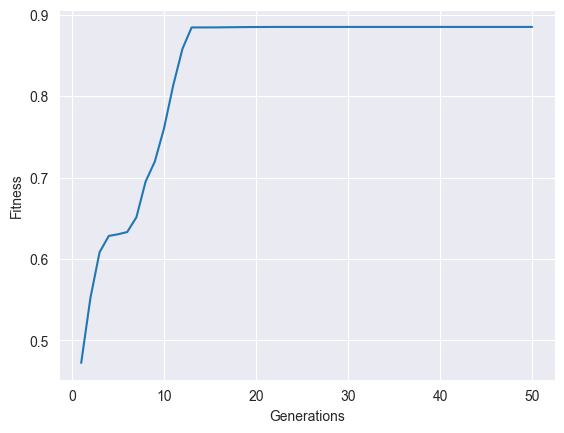

In [63]:
import matplotlib.pyplot as plt
plt.plot([x['gen'] for x in logbook[1:]], [x['avg'] for x in logbook[1:]])
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.show()